# 95-869: Big Data and Large-Scale Computing Homework 5


## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset_challenge/dataset).

#### ** This assignment will cover: **
*  *Part 1 (30 Points):* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
*  *Part 2 (15 Points):* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/2.2.0/mllib-ensembles.html)
*  *Part 3 (20 Points):* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html)
*  *Part 4 (15 Points):* Topic modeling for text reviews [Link](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda)
*  *Part 5 (10 Points):* Word2Vec for text reviews [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec)
*  *Part 6 (10 Points):* Frequent pattern mining using FP-Growth algorithm [Link](https://spark.apache.org/docs/2.2.0/mllib-frequent-pattern-mining.html)
*  *Part 7 (Bonus: 20 Points):* Any additional and insightful exploratory data analysis or machine learning tasks you want to do.

#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Code of Conduct **

** Please follow the following guidelines with respect to collaboration: **

* By using the dataset, you agree to Yelp's terms of use available [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).
* You are free to use the Web, APIs, ML toolkits, etc. in this project to your best benefit. Please cite any online or offline sources (even casual sources like StackOverflow) if you use them in the project.
* The assignment is to be done individually. No collaboration is allowed between students. No discussion is allowed about the project with anyone else except the class instructors.

## Submission Instructions:


You will submit both an html and a Jupyter Notebook on Canvas. You will submit a PDF on Gradescope and assign the pages to their corresponding questions. No printout submission is expected. The submission issues below will result in points deduction:

1. If the student doesn't make the submission on both Canvas and Gradescope: -5% 
2. If the student submits an empty jupyter notebook/version obviously different from the submitted PDF: -5%
3. If the student does't assign pages to questions on Gradescope: -3%

Rename the notebook from "hw5_yelp_student.ipynb" to "studentid_hw5_yelp_student.ipynb" where "studentid" is your Andrew ID. Complete the assignment, execute all cells in the completed notebook, and make sure all results show up. Export the contents of the notebook by choosing "File > Download as > HTML" and saving the resulting file as "studentid_hw5_yelp_student.html" Convert the exported HTML file to PDF by using a feature such as the "Save as PDF" feature on Mac. Another way to get the PDF file is to do ctrl(or command) + P and save as a PDF. Submit the PDF solution to gradescope. Submit the IPython and exported html solution files on Canvas.

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import nltk
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "25g").getOrCreate()
sc = spark.sparkContext
sc

23/04/30 22:27:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents,  numSlices=500)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question1: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
from collections import Counter

# Extract the categories from the RDD
categories_rdd = businesses_rdd.flatMap(lambda business: business["categories"])

# Count the occurrences of each category
category_count = categories_rdd.countByValue()

# Find the top 5 business categories by frequency using Counter
top_categories = Counter(category_count).most_common(5)

# Print the top 5 business categories and their frequencies
for category, count in top_categories:
    print(f"{category}: {count}")

Restaurants: 21892
Shopping: 8919
Food: 7862
Beauty & Spas: 4738
Nightlife: 4340


** Question2: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>
cities_rdd = businesses_rdd.map(lambda business: business["city"])

# Count the occurrences of each category
city_count = cities_rdd.countByValue()

# Find the top 5 business cities by frequency using Counter
top_cities = Counter(city_count).most_common(5)

# Print the top 5 cities and their frequencies
for city, count in top_cities:
    print(f"{city}: {count}")


Las Vegas: 13601
Phoenix: 8410
Charlotte: 4224
Scottsdale: 4039
Edinburgh: 3031


** Question3: ** Plot the histogram of stars received by businesses.

Text(0, 0.5, 'Number of Businesses')

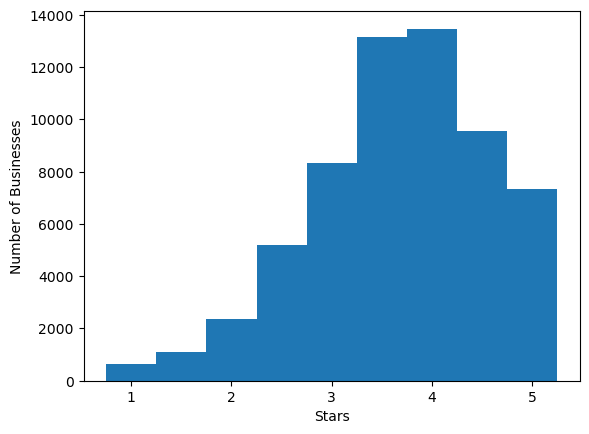

In [11]:
# TODO: Replace <FILL IN>

businesses_stars_counts = businesses_rdd.map(lambda business: business["stars"]).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question4: ** Plot the histogram of number of reviews received by businesses.

Text(0, 0.5, 'Number of Businesses')

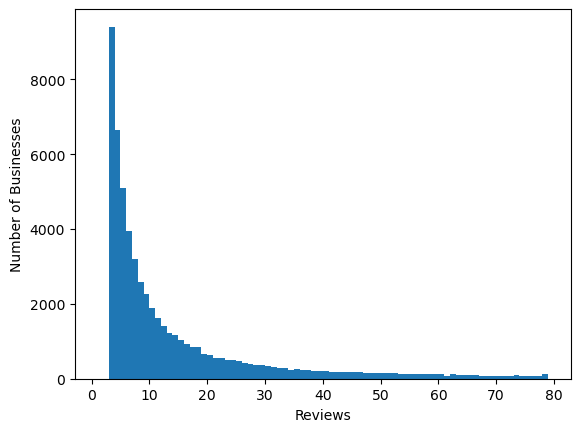

In [12]:
# TODO: Replace <FILL IN>

businesses_review_counts = businesses_rdd.map(lambda business: business["review_count"]).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Reviews')
plt.ylabel('Number of Businesses')

** Question5: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. We can see a straight line in the histogram plotted between log reviews and log businesses. This explains an exponential relationship between the two features. As we can see, there a large number of businesses that received log of reviews in the range of 10 and 100. But there are very few businesses that have got a large number of reviews. 

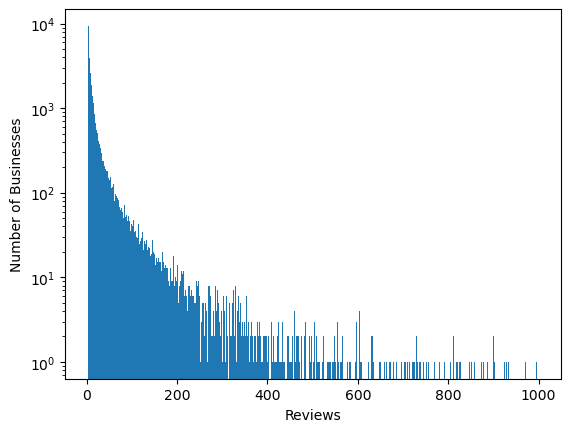

In [13]:
# TODO: Replace <FILL IN>
# Plot the histogram on a log-log scale
fig, ax = plt.subplots()
hist, bins, _ = ax.hist(businesses_review_counts, bins=range(1, 1000), log=True)
plt.xlabel('Reviews')
plt.ylabel('Number of Businesses')
plt.show()

** Question6: ** Plot the histogram of number of reviews written by users.

Text(0, 0.5, 'Number of Users')

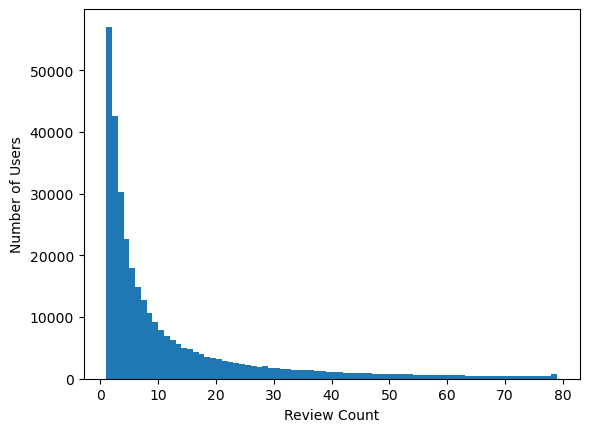

In [14]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda user: user["review_count"]).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question7: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. We can see a straight line in the histogram plotted between log reviews and log users. This explains an exponential relationship between the two features. As we can see, there a large number of users that wrote few reviews. But there are very few large # of reviews that have been given by users. 

Text(0, 0.5, 'Number of Users')

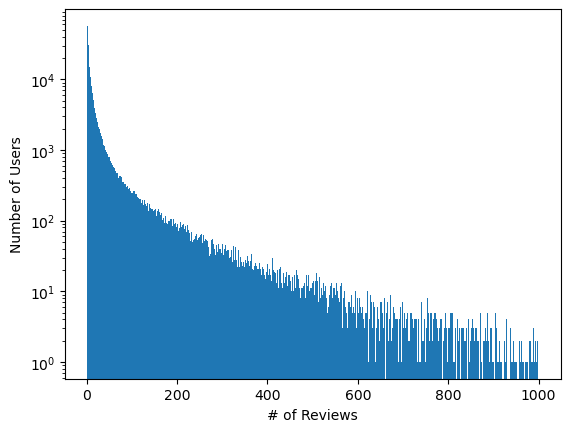

In [15]:
# TODO: Replace <FILL IN>
fig, ax = plt.subplots()
hist, bins, _ = ax.hist(users_review_counts, bins=range(1, 1000), log=True)
plt.xlabel('# of Reviews')
plt.ylabel('Number of Users')

** Question8: ** Plot the histogram of number of friends a Yelp user has.

Text(0, 0.5, 'Number of Users')

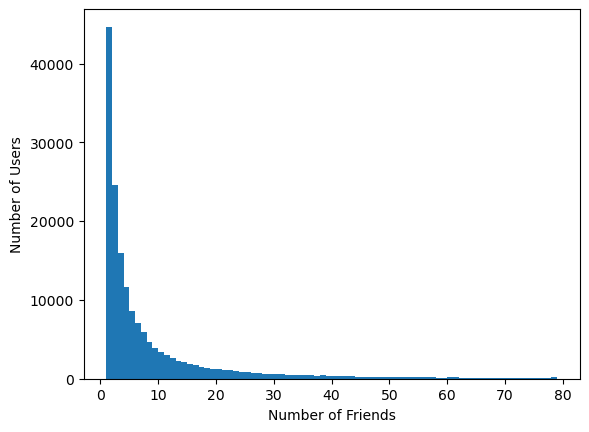

In [16]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda user: len(user["friends"])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question9: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. We can see a straight line in the histogram plotted between log users and log friends. This explains an exponential relationship between the two features. As we can see, there a large number of users that have few friends. But there are very few users that have lot of friends. 

Text(0, 0.5, 'Number of Users')

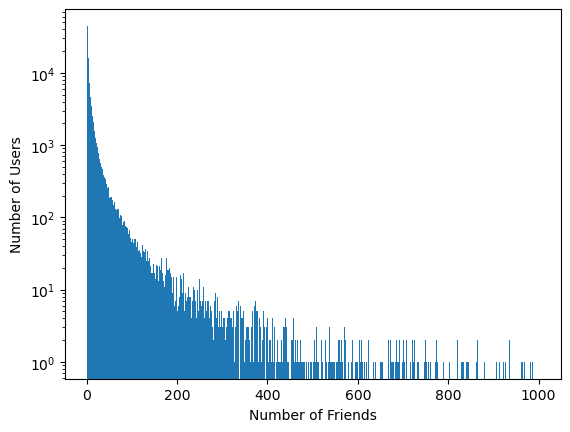

In [17]:
# TODO: Replace <FILL IN>
fig, ax = plt.subplots()
hist, bins, _ = ax.hist(user_friend_counts, bins=range(1, 1000), log=True)
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question10: ** Plot the histogram of number of fans a Yelp user has.

Text(0, 0.5, 'Number of Users')

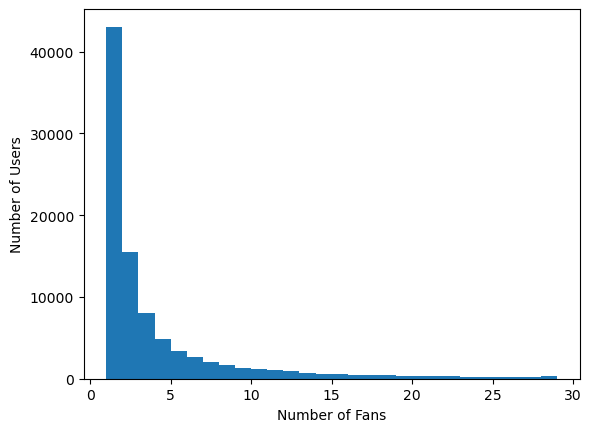

In [18]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda user: user["fans"]).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question11: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. We can see a straight line in the histogram plotted between log users and log fans. This explains an exponential relationship between the two features. As we can see, there a large number of users that have few fans. But there are very few users that have lot of fans. 

Text(0, 0.5, 'Number of Users')

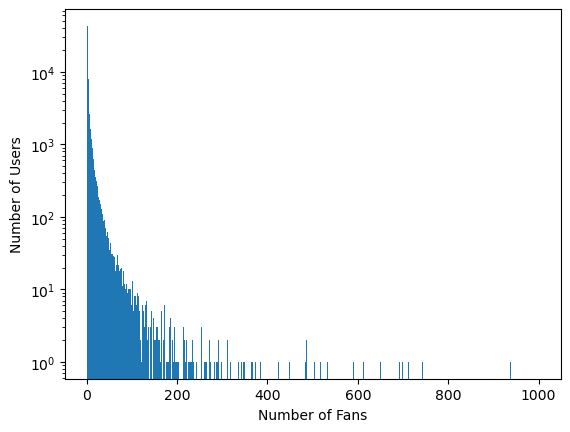

In [19]:
# TODO: Replace <FILL IN>
fig, ax = plt.subplots()
hist, bins, _ = ax.hist(users_fan_counts, bins=range(1, 1000), log=True)
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question12: ** Plot the histogram of number of checkins per Yelp business.

Text(0, 0.5, 'Number of Businesses')

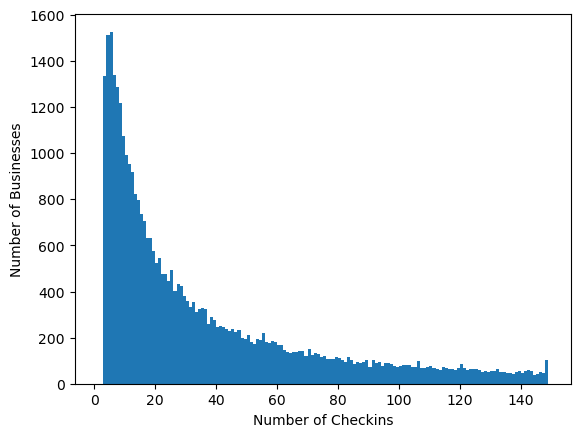

In [20]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda checkin: sum(checkin["checkin_info"].values())).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question13: ** Plot the above histogram but now on a log-log scale using `bins=range(3,200)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** No. Here, power law is violated. As we can see, there a large number of businesses that have few checkins. But there are also many businesses that have lot of checkins. 

Text(0, 0.5, 'Number of Businesses')

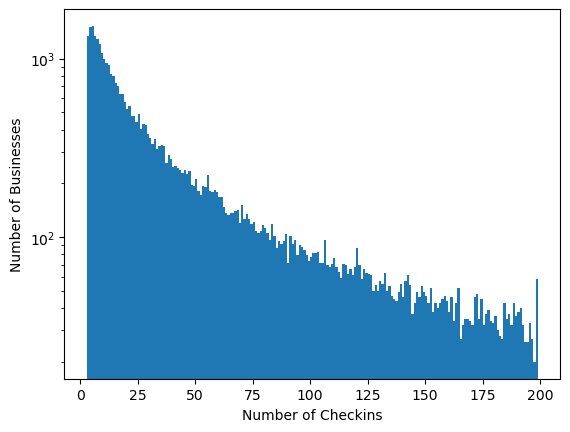

In [21]:
# TODO: Replace <FILL IN>
fig, ax = plt.subplots()
hist, bins, _ = ax.hist(business_checkin_counts, bins=range(3, 200), log=True)
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question14: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [22]:
# TODO: Replace <FILL IN>
max_checkin_count = checkins_rdd.map(lambda checkin: len(checkin["checkin_info"])).max()
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda checkin: len(checkin["checkin_info"]) == max_checkin_count) \
    .map(lambda checkin: checkin["business_id"]).collect()
len(business_ids_with_max_checkins)

41

In [23]:
# TODO: Replace <FILL IN>
business_names_with_max_checkins = businesses_rdd \
    .filter(lambda business: business["business_id"] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question15: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** Some possible reasons are the following: 
1. High-quality services: This attracts more customers, leading to more check-ins.
2. Convenient location: Located in prime locations near airport, making them more accessible to potential customers.
3. Social media influence: More reviews on platforms like yelp, google reviews attracting more customers

** Question16: ** Plot a histogram of the stars associated with business reviews.

Text(0, 0.5, 'Number of Reviews')

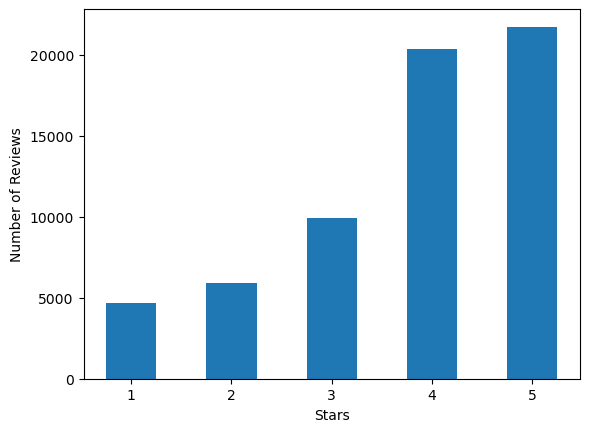

In [24]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda review: review["stars"]).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question17: ** Plot a histogram of the number of reviews written per Yelp user.

Text(0, 0.5, 'Number of Users')

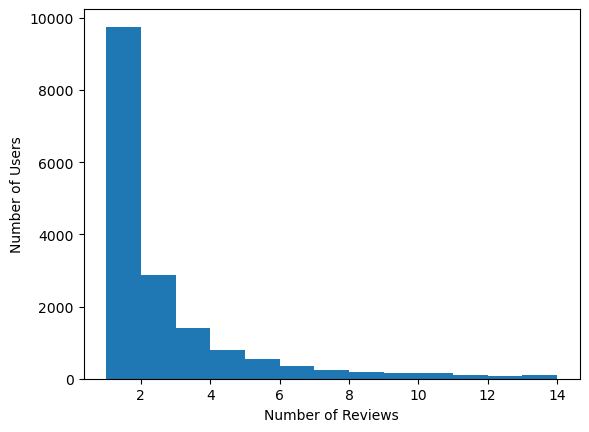

In [25]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda review: review["user_id"]).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question18: ** Plot a histogram of the number of reviews written per Yelp business.

Text(0, 0.5, 'Number of Businesses')

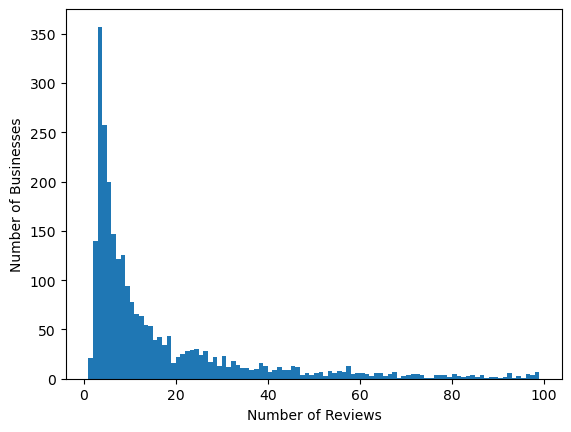

In [26]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda review: review["business_id"]).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question19: ** Plot a histogram of the number of useful votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

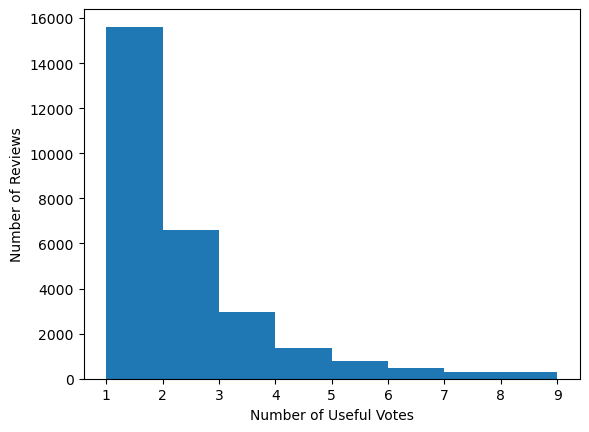

In [27]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda review: review["votes"]["useful"]).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question20: ** Plot a histogram of the number of funny votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

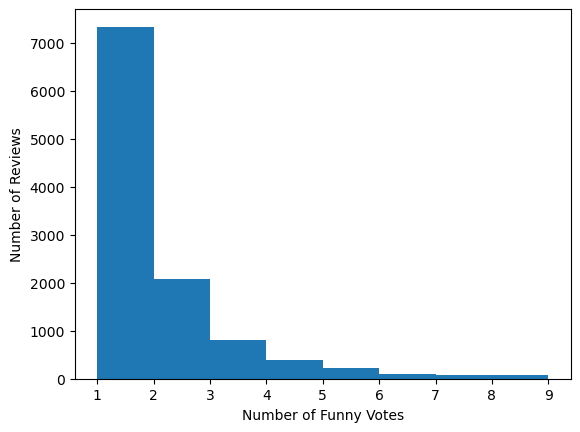

In [28]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda review: review["votes"]["funny"]).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question21: ** Plot a histogram of the number of cool votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

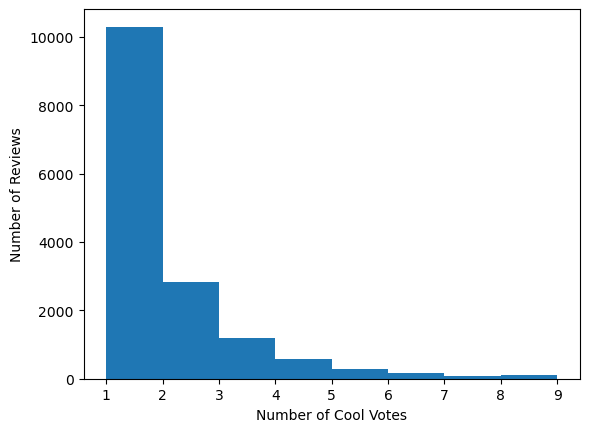

In [29]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda review: review["votes"]["cool"]).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question22: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

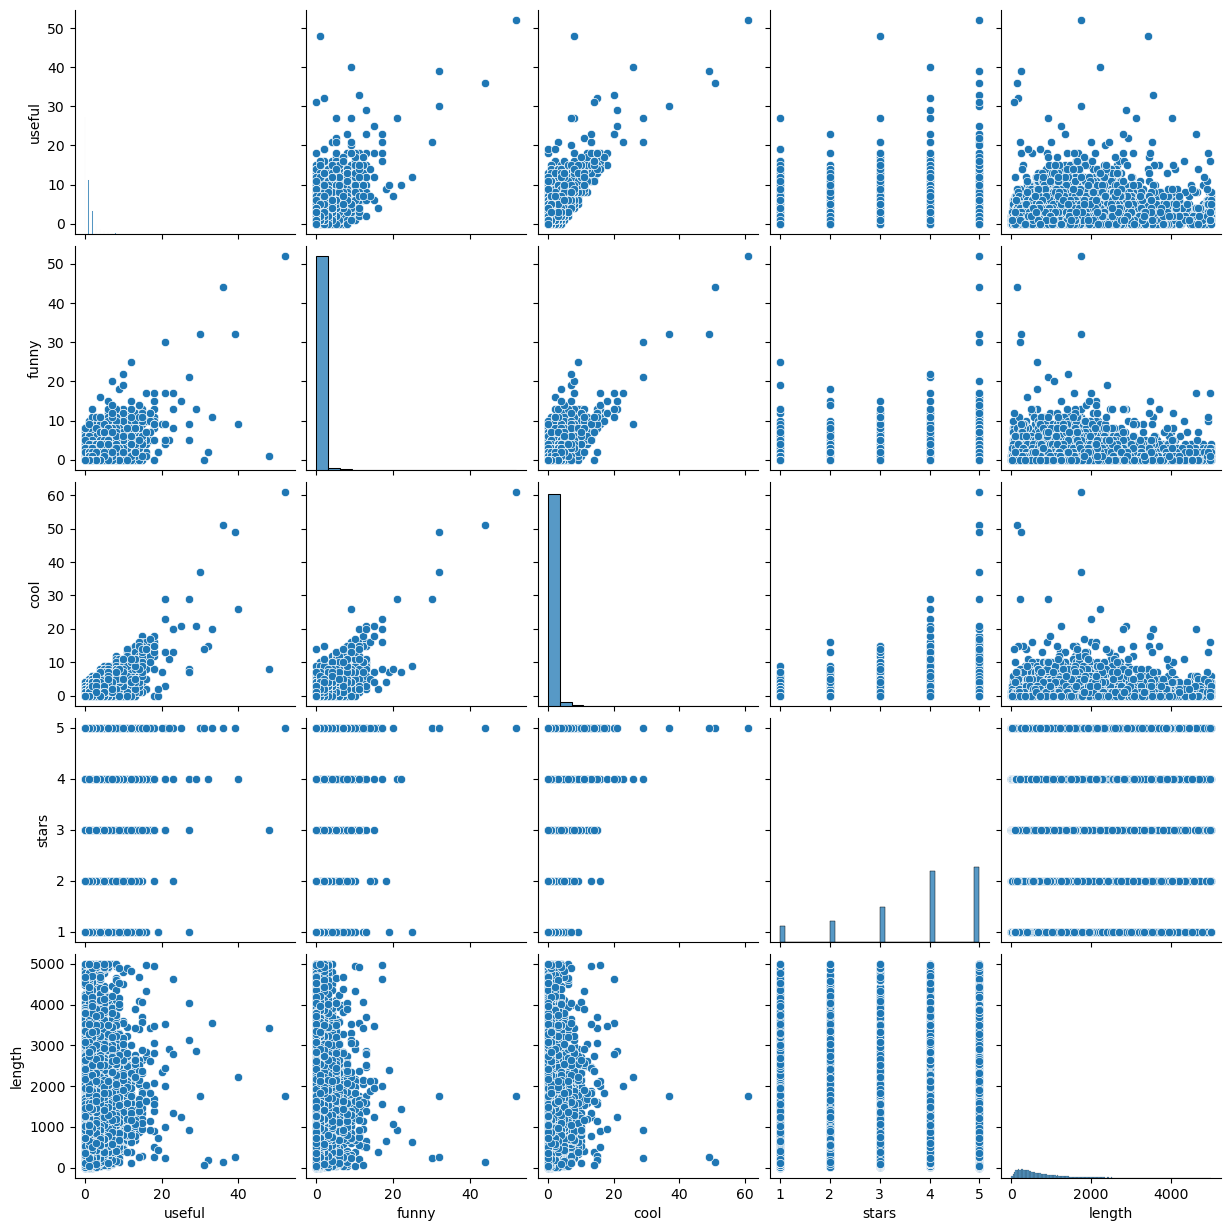

In [30]:
# TODO: Replace <FILL IN>

review_votes_length = reviews_rdd.map(lambda review: (review["votes"]["useful"],
                                                      review["votes"]["funny"],
                                                      review["votes"]["cool"],
                                                      review["stars"],
                                                      len(review["text"]))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question23: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [31]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda user: user["name"] in male_names)
female_users = users_rdd.filter(lambda user: user["name"] in female_names)

male_user_ids = male_users.map(lambda user: user["user_id"]).collect()
female_user_ids = female_users.map(lambda user: user["user_id"]).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question24: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [32]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda review: review["user_id"] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda review: review["user_id"] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda text: len(text.split()))
female_word_count = female_reviews.map(lambda text: len(text.split()))

male_avg_review_length = male_word_count.mean()
female_avg_review_length = female_word_count.mean()

print ('Male and female review length averages: ', male_avg_review_length, female_avg_review_length)

Male and female review length averages:  127.3470787972135 139.21062276751027


** Question25: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** There isnt any significant difference. 
However, females generally write longer reviews than males. This is seen in the distributions. 
The shorter and longer reviews are the same among male and females. Only in reviews having # of words between 125 and 475, females' reviews are more than males

In [33]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

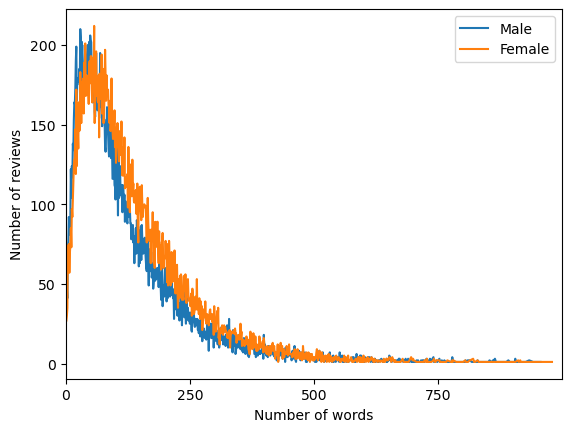

In [34]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [35]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question1: ** Fill in the necessary code to calculate word counts from text reviews below.

In [36]:
# TODO: Replace <FILL IN>

max_words = 50000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x: x[0].lower().split()).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  50000


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [37]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]: i for i in range(len(unique_words))}
index_to_word_dict = {i: unique_words[i] for i in range(len(unique_words))}

** Question3: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [38]:
# TODO: Replace <FILL IN>
doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0], SparseVector(len(word_to_index_dict), sorted(set(x[1])), [1.0]*len(set(x[1])))))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (50000,[0,1,2,3,4,6,8,9,11,12,14,15,16,22,25,38,44,52,58,79,99,102,116,144,162,182,289,307,334,352,362,456,470,656,672,711,740,888,928,931,984,1008,1114,1311,2209,2315,2805,3249,3738,3965,4148,4166,4530,5305,5391,5700,14456,15371],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (50000,[0,4,5,8,9,15,17,30,36,42,45,47,73,74,98,100,127,172,229,292,300,304,352,363,364,425,456,564,628,906,908,973,2805,3231,5799,6281,9776,13656,16459,18524],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


** Question4: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [39]:
# TODO: Replace <FILL IN>
doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8, 0.2], seed=0)

** Question5: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [40]:
# TODO: Replace <FILL IN>

most_common_prediction = sorted(doc_vectors_train.map(lambda lp: lp.label).countByValue().items(), key=lambda x: -x[1])[0][0]
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.0672479212077177
Learned baseline prediction:  0.0


** Question6: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [41]:
# TODO: Replace <FILL IN>
dt_model = DecisionTree.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, impurity='variance', maxDepth=5)

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

23/04/30 22:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1160.7 KiB
23/04/30 22:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1794.2 KiB
23/04/30 22:29:09 WARN DAGScheduler: Broadcasting large task binary with size 1795.1 KiB
23/04/30 22:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1795.7 KiB
23/04/30 22:29:16 WARN DAGScheduler: Broadcasting large task binary with size 1796.4 KiB
23/04/30 22:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1797.0 KiB
23/04/30 22:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1303.2 KiB


Validation Root Mean Squared Error (Decision Tree) = 1.0737230552414534
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 23 nodes
  If (feature 46056 <= 0.5)
   If (feature 52 <= 0.5)
    If (feature 39307 <= 0.5)
     If (feature 11 <= 0.5)
      If (feature 19910 <= 0.5)
       Predict: 0.1743649965205289
      Else (feature 19910 > 0.5)
       Predict: 11.0
     Else (feature 11 > 0.5)
      If (feature 17363 <= 0.5)
       Predict: 0.3471738231646093
      Else (feature 17363 > 0.5)
       Predict: 7.2
    Else (feature 39307 > 0.5)
     Predict: 30.0
   Else (feature 52 > 0.5)
    If (feature 15465 <= 0.5)
     If (feature 32640 <= 0.5)
      If (feature 31874 <= 0.5)
       Predict: 0.530241151302995
      Else (feature 31874 > 0.5)
       Predict: 12.5
     Else (feature 32640 > 0.5)
      Predict: 19.0
    Else (feature 15465 > 0.5)
     Predict: 20.0
  Else (feature 46056 > 0.5)
   If (feature 12 <= 0.5)
    If (feature 6 <= 0.5)
     Predict: 0.0
   

** Question7: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [42]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, numTrees=10, featureSubsetStrategy="auto", impurity='variance', maxDepth=5, seed=0)

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

23/04/30 22:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1160.7 KiB
23/04/30 22:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/04/30 22:29:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/30 22:30:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/04/30 22:30:14 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/04/30 22:30:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/04/30 22:30:35 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
23/04/30 22:30:35 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/30 22:30:35 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Validation Root Mean Squared Error (Random Forest) = 0.9558091833955712
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 39307 <= 0.5)
     If (feature 150 <= 0.5)
      If (feature 29911 <= 0.5)
       If (feature 35 <= 0.5)
        If (feature 28284 <= 0.5)
         Predict: 0.2179126958839035
        Else (feature 28284 > 0.5)
         Predict: 11.0
       Else (feature 35 > 0.5)
        If (feature 5950 <= 0.5)
         Predict: 0.4108573890564412
        Else (feature 5950 > 0.5)
         Predict: 4.588235294117647
      Else (feature 29911 > 0.5)
       If (feature 11 <= 0.5)
        Predict: 2.0
       Else (feature 11 > 0.5)
        Predict: 15.0
     Else (feature 150 > 0.5)
      If (feature 15747 <= 0.5)
       If (feature 31342 <= 0.5)
        If (feature 22446 <= 0.5)
         Predict: 0.6604127579737336
        Else (feature 22446 > 0.5)
         Predict: 15.0
       Else (feature 31342 > 0.5)
        If (feature 20 <= 0.5)

** Question8: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** The number of iterations is equal to the number of trees in the ensemble. Yes, it affects the # of trees.
We do not need to set maximum depth of trees because it tries to correct the errors of the previous trees in a sequential manner and the trees used here are decision stumps (depth=1) and we can control the complexity of the model through the number of trees used

In [43]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, numIterations=10)

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

23/04/30 22:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1160.9 KiB
23/04/30 22:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1795.6 KiB
23/04/30 22:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1796.5 KiB
23/04/30 22:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1797.1 KiB
23/04/30 22:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1803.5 KiB
23/04/30 22:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1804.1 KiB
23/04/30 22:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1804.7 KiB
23/04/30 22:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1806.6 KiB
23/04/30 22:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1807.2 KiB
23/04/30 22:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1807.8 KiB
23/04/30 22:31:09 WARN DAGScheduler: Broadcasting large task binary with size 1809.8 KiB
23/04/30 22:31:11 WAR

Validation Root Mean Squared Error (Gradient Boosting Trees) = 1.06678101043372
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 46056 <= 0.5)
     If (feature 52 <= 0.5)
      If (feature 39307 <= 0.5)
       Predict: 0.24879160509905082
      Else (feature 39307 > 0.5)
       Predict: 30.0
     Else (feature 52 > 0.5)
      If (feature 15465 <= 0.5)
       Predict: 0.5343637600855449
      Else (feature 15465 > 0.5)
       Predict: 20.0
    Else (feature 46056 > 0.5)
     If (feature 12 <= 0.5)
      If (feature 6 <= 0.5)
       Predict: 0.0
      Else (feature 6 > 0.5)
       Predict: 1.0
     Else (feature 12 > 0.5)
      Predict: 52.0
  Tree 1:
    If (feature 17 <= 0.5)
     If (feature 22066 <= 0.5)
      If (feature 25371 <= 0.5)
       Predict: -0.15738879910281123
      Else (feature 25371 > 0.5)
       Predict: 25.502416789801828
     Else (feature 22066 > 0.5)
      Predict: 29.502416789801828
    Else (feature 17 > 0.5)
   

** Question9: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** Random Forest has the lowest RMSE

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [44]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question1: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [45]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda review: review['user_id']).distinct().collect()
review_business_ids = reviews_rdd.map(lambda review: review['business_id']).distinct().collect()

user_to_index_dict = {review_user_ids[i]: i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]: i for i in range(len(review_business_ids))}

** Question2: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [46]:
# TODO: Replace <FILL IN>

ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']],
                                                    business_to_index_dict[x['business_id']],
                                                    float(x['stars'])))
print(ratings_rdd.take(2))

[Rating(user=14449, product=1855, rating=5.0), Rating(user=5866, product=1855, rating=2.0)]


** Question3: ** Let us randomly split data into 80% train and 20% validation set.

In [47]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8, 0.2])

** Question4: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [48]:
# TODO: Replace <FILL IN>

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train, rank=rank, iterations=numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

23/04/30 22:32:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/30 22:32:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/04/30 22:32:48 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=1) = Train 2.2510278011448706, Validation 8.15444275112275


23/04/30 22:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=2) = Train 0.7488240671922028, Validation 2.6313136254853418


23/04/30 22:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:33:39 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=3) = Train 0.6815517042749296, Validation 2.7373622440217846


23/04/30 22:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=4) = Train 0.5395510911272018, Validation 2.501727749262729


23/04/30 22:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=5) = Train 0.47525822087177294, Validation 2.215550098738347


23/04/30 22:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=6) = Train 0.4430414183336026, Validation 2.291467511508185


23/04/30 22:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:35:13 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=7) = Train 0.39932826115442976, Validation 2.155409276528969


23/04/30 22:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=8) = Train 0.36776830681869216, Validation 2.097009541931733


23/04/30 22:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=9) = Train 0.34899048960365714, Validation 2.134740462091387


23/04/30 22:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=10) = Train 0.3275627747809437, Validation 2.18902041243086


23/04/30 22:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=11) = Train 0.30872223667172216, Validation 2.1759335475153767


23/04/30 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=12) = Train 0.2886932541512754, Validation 2.1261414875563163


23/04/30 22:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=13) = Train 0.2740880161520304, Validation 2.089543044465042


23/04/30 22:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:38:07 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=14) = Train 0.26175105219413897, Validation 2.0632212829221683


23/04/30 22:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=15) = Train 0.25128447916838953, Validation 2.0710746918042755


23/04/30 22:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:38:59 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=16) = Train 0.2430549135691912, Validation 2.082420803077882


23/04/30 22:39:21 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:39:24 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=17) = Train 0.2332660056547698, Validation 1.95841470919879


23/04/30 22:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=18) = Train 0.22655350515972236, Validation 2.0116898221909634


23/04/30 22:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=19) = Train 0.21922569811921103, Validation 1.9980019679114482


23/04/30 22:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:40:41 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=20) = Train 0.21333365263130435, Validation 1.9636691290685484


23/04/30 22:41:04 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=40) = Train 0.18728325235185767, Validation 1.74614593100712


23/04/30 22:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=60) = Train 0.1855175755259221, Validation 1.628357614584002


23/04/30 22:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=80) = Train 0.185071117028088, Validation 1.6054316927422752


23/04/30 22:42:21 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:42:24 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=100) = Train 0.18483818045054354, Validation 1.601459841843747


23/04/30 22:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/04/30 22:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=120) = Train 0.18487581629386884, Validation 1.5736282926258598


23/04/30 22:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB
23/04/30 22:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB


Root Mean Squared Error (rank=140) = Train 0.18474106766641266, Validation 1.5679474536528637


23/04/30 22:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB
23/04/30 22:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB


Root Mean Squared Error (rank=160) = Train 0.18477419331550296, Validation 1.5546719700281915


23/04/30 22:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB
23/04/30 22:44:10 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB


Root Mean Squared Error (rank=180) = Train 0.18473281834053376, Validation 1.565783827267214


23/04/30 22:44:34 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB
23/04/30 22:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB


Root Mean Squared Error (rank=200) = Train 0.18473319450122808, Validation 1.555880541516929


** Question5: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** Based on the plots, I choose rank=25 as for this value both train and validation RMSE are low.
And I do not recommend doing hyperparameter tuning with more rank values because the RMSE for both train and validation became constant after rank 25. So it does not make sense to try after higher ranks

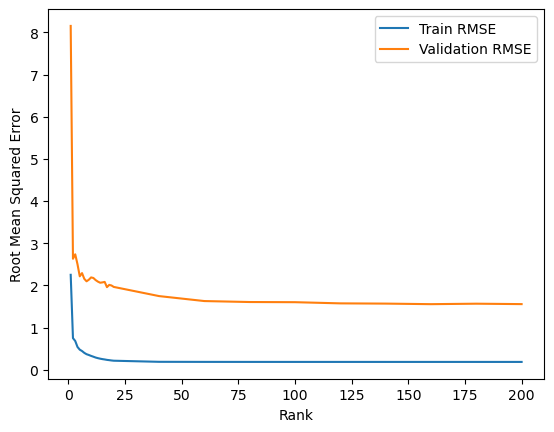

In [49]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [50]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question1: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [51]:
# TODO: Replace <FILL IN>

# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x: x['text'])
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x: -x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  192742


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [52]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]: i for i in range(len(unique_words))}
index_to_word_dict = {i: unique_words[i] for i in range(len(unique_words))}

** Question3: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [53]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x: SparseVector(num_unique_words, [(i, x.count(i)) for i in set(x)]))
# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x: [x[1], x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(192742, {8: 2.0, 114: 1.0, 311: 1.0, 1209: 1.0, 1315: 1.0, 1444: 1.0, 1805: 1.0, 1987: 1.0, 2249: 1.0, 2738: 1.0, 2965: 1.0, 3148: 1.0, 3166: 1.0, 3530: 1.0, 3614: 1.0, 3977: 1.0, 4305: 1.0, 4391: 1.0, 4700: 1.0, 6041: 1.0, 8947: 1.0, 11064: 1.0, 13456: 1.0, 14371: 1.0, 23207: 1.0, 54812: 1.0, 77509: 1.0, 77510: 1.0, 77511: 1.0, 77512: 1.0})], [1, SparseVector(192742, {1805: 1.0, 2231: 1.0, 4799: 1.0, 5281: 1.0, 8776: 1.0, 12656: 1.0, 15459: 1.0, 17524: 1.0})]]


** Question4: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [54]:
# TODO: Replace <FILL IN>
lda_model = LDA.train(doc_vectors, k=100, seed=42)

** Question5: ** Display the LDA model vocabulary size.

In [55]:
# TODO: Replace <FILL IN>

print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  192742


** Question6: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

**Answer** Yes since we are considering Yelp dataset that has details/reviews about restaurants, hotels - the topics learned are also closely associated with these 


In [56]:
# TODO: Replace <FILL IN>
topics = lda_model.topicsMatrix()
num_top_words = 100
for topic_idx in range(5):
    print("Topic #{}:".format(topic_idx))
    top_words = [index_to_word_dict[i] for i in topics[topic_idx,:].argsort()[-num_top_words:]]
    print(" ".join(top_words))
    print("Semantic label/meaning:")
    if topic_idx == 0:
        print("Food")
    elif topic_idx == 1:
        print("Rooms")
    elif topic_idx == 2:
        print("Service")
    elif topic_idx == 3:
        print("Ambience")
    elif topic_idx == 4:
        print("Location")
    print()

Topic #0:
cook life apple special. bottom wait. chili drink. means greasy choices true noodle hostess supposed perfect. stayed side, burrito tasty, room. hand pancakes fresh. picked orders thank great! thinking mine weeks atmosphere, thick location. else. inside. small, amazing! oil covered generally normally total bread. town. except they've sign you, la minutes. minute you'd times. visit. penn best. pricey longer terrible we're thin share nearly creamy meal, honestly up, bean somewhere okay, please charge selection. recommended area, pizza, paying whatever dressing wall rooms finished avoid seriously pepper ... forget personal card clearly general limited employees , is, and, bars recent sour
Semantic label/meaning:
Food

Topic #1:
okay, rooms personal pricey hostess thick side, thinking times. life dressing recommended sign perfect. they've selection. minute supposed stayed bottom else. ... employees bars up, visit. sour greasy except small, share choices wait. room. town. is, gener

# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [57]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [58]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question1: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [59]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).setNumIterations(10).fit(review_docs)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [60]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['cholula', 'fluff', 'milkshake', 'concoction', 'starch']
Words most similar to  pepper  :  ['celery', 'chilies', 'garlic', 'chutney', 'anchovy']
Words most similar to  restaurant  :  ['resturant', 'restaraunt', 'establishment', 'location', 'particular']
Words most similar to  italian  :  ['style', 'greek', 'shacks', 'homestyle', 'traditional']
Words most similar to  indian  :  ['chinese', 'mexican', 'chinesetaiwanese', 'cuisine', 'japanese']
Words most similar to  chinese  :  ['indian', 'mexican', 'chinesetaiwanese', 'japanese', 'cuisine']
Words most similar to  direction  :  ['driveway', 'journey', 'anger', 'upmc', 'greyhound']
Words most similar to  pittsburgh  :  ['pgh', 'connecticut', 'bloomfield', 'burgh', 'dc']
Words most similar to  burgh  :  ['city', 'berlin', 'squirrell', 'los', 'robinson']
Words most similar to  city  :  ['robinson', 'burg', 'bloomfield', 'eastside', 'burgh']
Words most similar to  location  :  ['neighborhood', 'scene', 'toons

** Question2: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: **  Spurious: Milkshake, cholula for salt ; direction -> anger
location -> toonseum

Synonyms that are perfect: 

chinese -> chinesetaiwanese
indian -> cuisine
pittsburgh -> burgh


# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [61]:
from pyspark.mllib.fpm import FPGrowth

** Question1: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [62]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda business: business['categories'])

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.01, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/04/30 22:53:53 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question2: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [63]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.001, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/04/30 22:53:56 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question3: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** Yes all the items in support threshold 0.01 are included in 0.001 because the former is just a subset of the latter with the latter having additional related words due to lower support values

# ** Part 7: Bonus Analysis (if any) **

Here, you can include any additional and insightful exploratory data analysis or machine learning tasks you have carried out in addition to the guided exploration of the dataset above. Feel free to add code/markdown cells here to present your analysis.

In [64]:
# Count the number of users by year they joined Yelp
user_by_year = users_rdd.map(lambda x: (x['yelping_since'][:4], 1)) \
                       .reduceByKey(lambda x, y: x + y) \
                       .sortBy(lambda x: x[0])
print("Number of users by year they joined Yelp:")
print(user_by_year.collect())

Number of users by year they joined Yelp:
[('2004', 51), ('2005', 691), ('2006', 3974), ('2007', 10676), ('2008', 19390), ('2009', 32968), ('2010', 50722), ('2011', 69210), ('2012', 63897), ('2013', 63483), ('2014', 50505), ('2015', 1148)]


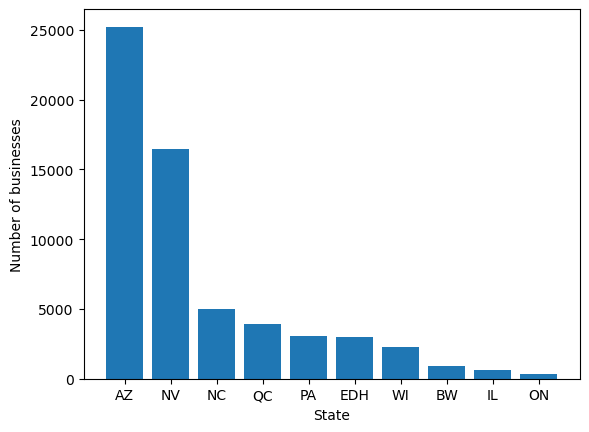

In [65]:
# Create a bar chart of the number of businesses by state
business_by_state = businesses_rdd.map(lambda x: (x['state'], 1)) \
                                .reduceByKey(lambda x, y: x + y) \
                                .sortBy(lambda x: -x[1])
states = [x[0] for x in business_by_state.take(10)]
counts = [x[1] for x in business_by_state.take(10)]
plt.bar(states, counts)
plt.xlabel('State')
plt.ylabel('Number of businesses')
plt.show()

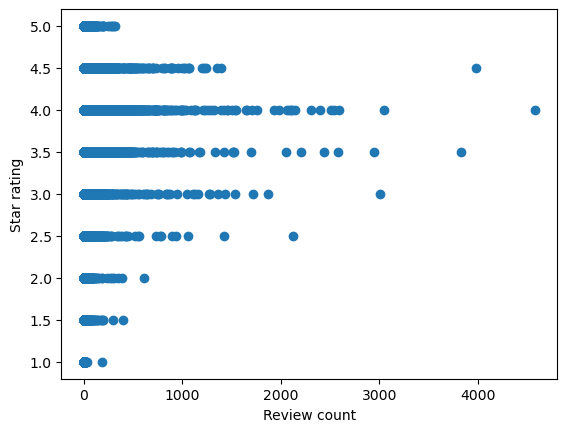

In [66]:
# Create a scatter plot of the relationship between review count and star rating
review_count = businesses_rdd.map(lambda x: x['review_count']).collect()
star_rating = businesses_rdd.map(lambda x: x['stars']).collect()
plt.scatter(review_count, star_rating)
plt.xlabel('Review count')
plt.ylabel('Star rating')
plt.show()

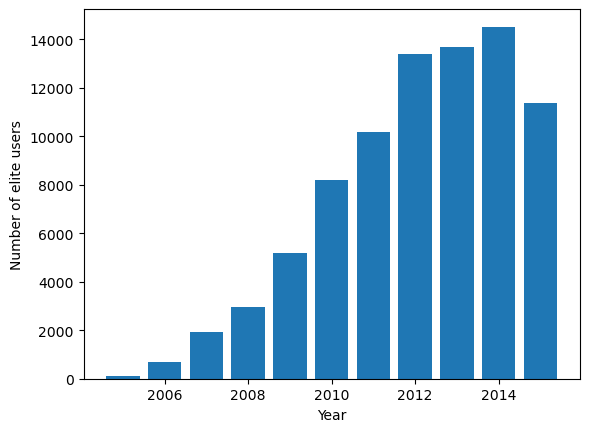

In [67]:
# Create a bar chart of the number of elite users by year
user_by_year = users_rdd.flatMap(lambda x: x['elite']) \
                       .map(lambda x: (x, 1)) \
                       .reduceByKey(lambda x, y: x + y) \
                       .sortBy(lambda x: x[0])
years = [x[0] for x in user_by_year.collect()]
counts = [x[1] for x in user_by_year.collect()]
plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Number of elite users')
plt.show()

In [68]:
# Calculate the average number of reviews per user by elite customer status
reviews_by_elite = users_rdd.map(lambda x: (len(x['elite']) > 0, x['review_count'])) \
                           .groupByKey() \
                           .mapValues(lambda x: sum(x) / len(x)) \
                           .sortBy(lambda x: x[0], ascending=False)

# Print the average number of reviews per user by elite status
print('Average number of reviews per user by elite status:')
for elite, count in reviews_by_elite.collect():
    status = 'Elite' if elite else 'Non-elite'
    print(f"{status}: {count:.2f}")

Average number of reviews per user by elite status:
Elite: 245.09
Non-elite: 16.44


In [69]:
# Calculate the average star rating by state
stars_by_state = businesses_rdd.map(lambda x: (x['state'], x['stars'])) \
                             .groupByKey() \
                             .mapValues(lambda x: sum(x) / len(x)) \
                             .sortBy(lambda x: -x[1])

# Print the top 10 states with the highest average star rating
print('Top 10 states with the highest average star rating:')
for state, stars in stars_by_state.take(10):
    print(f"{state}: {stars:.2f}")

Top 10 states with the highest average star rating:
MN: 5.00
MA: 5.00
WA: 5.00
NW: 5.00
HAM: 4.50
RP: 4.23
SCB: 4.00
MLN: 3.83
EDH: 3.79
BW: 3.77


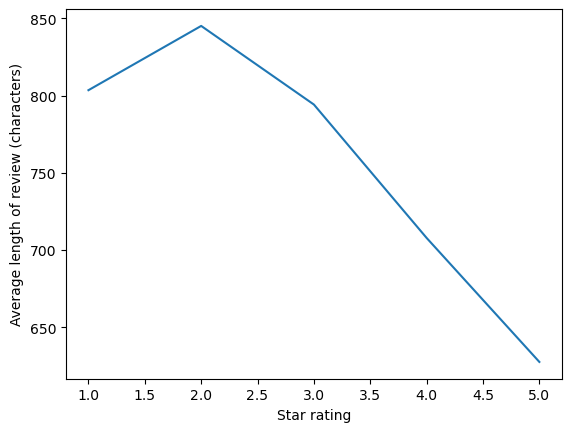

In [70]:
# Calculate the average length of reviews by star rating
reviews_by_length = reviews_rdd.map(lambda x: (x['stars'], len(x['text']))) \
                              .groupByKey() \
                              .mapValues(lambda x: sum(x) / len(x)) \
                              .sortBy(lambda x: x[0])

# Plot a line chart of the average length of reviews by star rating
stars = [x[0] for x in reviews_by_length.collect()]
lengths = [x[1] for x in reviews_by_length.collect()]
plt.plot(stars, lengths)
plt.xlabel('Star rating')
plt.ylabel('Average length of review (characters)')
plt.show()